# Milestone 2

## Busting the left brain vs. right brain myth ?

**Abstract:**

We are often put into boxes regarding our interests and hobbies, we have friends with the same interests as us, we chose a department when we are young at high school and social media makes a lot of suggestions based on our past interests. We sometimes hear that artistic and scientific people are different, closed-minded in their subject, and not interested in the other one. As an example, there exists a popular myth according to which "left-brained" people are more logical whereas "right-brained" people are more creative.

The goal of this project is to study this stereotype by studying the YouNiverse dataset at our disposition using comments and video metadata files. We want to determine whether users who usually comment on artistic videos also comment on scientific videos (and vice-versa). Our goal is also to split artistic and scientific videos into smaller domains to analyze if this effect is influenced by the particular domain of science/art in which the user is interested. To draw some conclusions about people’s interests, we can determine the user profiles and the watching/commenting behaviors w.r.t. videos that do not usually match their profiles.

## Useful libraries

In [18]:
import sys

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import numpy as np
np.random.seed(0xdeadbeef) # set random seed

import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'

import seaborn as sns
sns.color_palette("colorblind")
sns.set_theme()

from datetime import datetime
from wordcloud import WordCloud

from scipy import stats
import statsmodels.formula.api as smf

import networkx as nx
from networkx.algorithms import bipartite

## Data preprocessing

### Data sampling

Since we are studying youtube users, we choose to start the data sampling from them.

What we do is recover a fixed number of users, let's say around 1 million on carry on our analysis on the video they commented on. We assume that with enough users, we will have a large enough sample of videos to be representative of all the videos.

Furthermore, we can take the first chunk of the comment file since the user are ordered in a random way.

In [ ]:
raw_comments_filename = 'raw_data/youtube_comments.tsv.gz'
raw_video_metadata_filename = 'raw_data/yt_metadata_en.jsonl.gz'

In [ ]:
chunksize = 12e6 + 1    # add one so we have a nice round number because we remove the last user 

# get one chunk of comments to recover num_users
for df_comments in pd.read_csv(raw_comments_filename, sep='\t', chunksize=chunksize, compression='infer'):
    
    # Since the last author could be cutoff, we remove the last author
    df_comments = df_comments[df_comments.author != df_comments.iloc[-1]['author']]

    print('Number of users: %d' % len(df_comments.author.unique()))        # should bebetween 500 000 and 1 million

    df_comments.to_feather('comments.feather')

    break

KeyboardInterrupt: 

In [ ]:
df_comments.head()

,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


In [ ]:
# Get unique video ids
video_ids = pd.DataFrame({'video_id': df_comments['video_id'].unique()})
print('Number of videos: %d' % len(video_ids))

Number of videos: 4136765


In [ ]:
# clear memory before handling more data
print('Cleared %d bytes of memory' % sys.getsizeof(df_comments))
%xdel df_comments

Cleared 1199999816 bytes of memory


After gathering our user and identifying what videos they commented on, we recover metadata on these video for our analysis by computing the intersection chunkwize of the total video set and the videos our sample of user have commented on.

In [ ]:
# They are around 73M videos in this file
chunksize = 500e3
max_num_chunk = 74e6 // chunksize

# Define dtypes to have to most memory optimization possible
# After some tests, using dtypes seems to be a little bit beneficial
# One chunk:  
#   - without dtypes:
#       time: 32.7s
#       space: 62574070 B
#   - with dtypes
#       time: 29.8s
#       space: 56003766 B

dtype = {
    'title': str,
    'display_id': str,
    'description': str,
    'categories': 'category',
    'crawl_date': str,
    'upload_date': str,
    'dislike_count': int,
    'like_count': int,
    'duration': int,
    'view_count': int,
    'tags': object,
}

dfs = []
chunk_num = 1
for chunk in pd.read_json(raw_video_metadata_filename, dtype=dtype, chunksize=chunksize, lines=True):

    # remove unused fields for space optimizations: title, description, crawldate
    chunk.drop(['title', 'description', 'crawl_date'], axis=1 , inplace=True)

    # keep only videos where one of our user in our user pool commented
    # then remove redudant column display_id
    chunk = pd.merge(chunk, video_ids, left_on='display_id', right_on='video_id').drop('display_id', axis=1)

    print('Chunk %d out of %d. Kept %d out of %d videos.' % (chunk_num, max_num_chunk, len(chunk), chunksize))

    dfs.append(chunk)

    chunk_num += 1
    

videos_metadata = pd.concat(dfs).reset_index(drop=True)

# Save videoset
videos_metadata.to_feather('video_metadata.feather')

Chunk 1 out of 148. Kept 34962 out of 500000 videos.
Chunk 2 out of 148. Kept 26111 out of 500000 videos.
Chunk 3 out of 148. Kept 33473 out of 500000 videos.
Chunk 4 out of 148. Kept 28317 out of 500000 videos.
Chunk 5 out of 148. Kept 21542 out of 500000 videos.
Chunk 6 out of 148. Kept 43322 out of 500000 videos.
Chunk 7 out of 148. Kept 29785 out of 500000 videos.
Chunk 8 out of 148. Kept 37594 out of 500000 videos.
Chunk 9 out of 148. Kept 24331 out of 500000 videos.
Chunk 10 out of 148. Kept 30089 out of 500000 videos.
Chunk 11 out of 148. Kept 25326 out of 500000 videos.
Chunk 12 out of 148. Kept 23741 out of 500000 videos.
Chunk 13 out of 148. Kept 21987 out of 500000 videos.
Chunk 14 out of 148. Kept 27249 out of 500000 videos.
Chunk 15 out of 148. Kept 30069 out of 500000 videos.
Chunk 16 out of 148. Kept 26012 out of 500000 videos.
Chunk 17 out of 148. Kept 30458 out of 500000 videos.
Chunk 18 out of 148. Kept 25333 out of 500000 videos.
Chunk 19 out of 148. Kept 31086 out o

### Data importation

In [2]:
df_videos = pd.read_feather("video_metadata.feather")[:1000000]

In [3]:
print(len(df_videos))
df_videos.head()

1000000


,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,11423.0,1762,29891.0,"lego city police for kids,lego polizi,lego mov...",2017-12-08 00:00:00,23152662.0,mp9gt45aHxY
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,1561.0,1146,6118.0,"lego dinosaurs,lego jurassic world,lego dinosa...",2017-12-07 00:00:00,4028426.0,hn2zYwqSINY
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,206.0,1706,2235.0,"lego marvel super heroes 2,lego super heroes 2...",2017-11-18 00:00:00,585746.0,UTZLSHaE4Sw
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,799.0,2146,2501.0,"lego dinosaurs,lego jurassic world,lego t-rex,...",2017-02-21 00:00:00,1547805.0,SWZG-ba1qDk
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"lego batman movie,the batman movie,new batman ...",2017-02-13 00:00:00,6674760.0,3vQK78eUg2A


### Data filtering

In [4]:
# Overview of the categories
df_videos.categories.value_counts()

Gaming                   287880
Entertainment            193551
People & Blogs            98111
Music                     83111
Howto & Style             63394
News & Politics           48787
Sports                    42052
Comedy                    39631
Education                 37773
Film & Animation          37175
Science & Technology      33433
Autos & Vehicles          17686
Travel & Events            8178
Pets & Animals             6402
Nonprofits & Activism      2830
                              6
Name: categories, dtype: int64

Artistic video category does not exist so we made ours, which allows us to define domains within this category. <br>
Science & Technology category does exist but a lot of scientific videos were also located in other categories and we also wanted to define sub-domains, therefore we had to define our own science category as well.


In [5]:
# Formatting the tags column in order to do exact word matching

df_videos['tags'] = df_videos['tags'].apply(str.lower)
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(';',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(',',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('(',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=(')',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('&',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.replace, args=('|',' ',))
df_videos['tags'] = df_videos['tags'].apply(str.split)

We removed the videos from the gaming catgory. They were often classified as artistic videos because of the gaming vocabulary (e.g. "craft" for Minecraft...) but weren't related with art. In general gaming videos have all kinds of random tags which isn't helpful for our analysis.

In [6]:
df_videos = df_videos.loc[df_videos.categories != "Gaming"] 
df_videos['upload_date'] = pd.to_datetime(df_videos['upload_date'])
df_videos.head()

,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"[lego, batman, movie, the, batman, movie, new,...",2017-02-13,6674760.0,3vQK78eUg2A
5,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,613.0,398,49464.0,"[vine, vines, vine, compilation, chaotic, good]",2019-02-05,1142835.0,BDnF-EgqAGw
6,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,588.0,375,32726.0,"[vines, vine, vine, compilation, neutral, good...",2019-01-31,819654.0,wrTIXbQED80
7,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,673.0,319,30596.0,[],2019-01-15,736707.0,yd7d51AgSso
8,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,991.0,367,75504.0,"[vine, vine, compilation, vines, lawful, good]",2019-01-09,1636316.0,-Ia18bqO-9w


Some helper functions

In [7]:
def return_word_in_list(tags, word_list):
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)

    return z

In [8]:
def check_tags_in_list(tags, word_list):
    word_present = 0
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)
    
    # If the intersection is larger than 0, then there is at least a common word between both sets 
    if len(z) > 0:
        word_present = 1
    return word_present

#### Artistic videos

We selected the three different art domains using the Wikipedia Arts page: https://en.wikipedia.org/wiki/The_arts, they are the following: Visual Art, Literary Art, Performing Art. <br>
We decided to use tags to categorise art and scientific domains. They represent better the content of the video because words usually have multiple meanings, therefore tags are more relevant than the description.<br>
We adapted the dictionaries to spot users who were interested in art and science. For example we removed music from performing art because we didn't define users as artistic just because they listen to music.


In [9]:
# Art words dictionaries
words_path_visual = "dictionaries/visual_arts.txt"
words_path_performing = "dictionaries/performing_art.txt"
words_path_literary = "dictionaries/literary_art.txt"

visual_arts = pd.read_csv(words_path_visual)
literary_arts = pd.read_csv(words_path_literary)
performing_arts = pd.read_csv(words_path_performing)

visual_words = visual_arts.values
literary_words = literary_arts.values
performing_words = performing_arts.values

visual_words = visual_words.flatten()
literary_words = literary_words.flatten()
performing_words = performing_words.flatten()

In [10]:
# See what kind of Art domains the videos fall under 

df_videos['visual_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, visual_words))
df_videos['literary_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, literary_words))
df_videos['performing_art'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, performing_words))
df_videos["art"] = 0
df_videos["art"].loc[(df_videos.visual_art == 1) | (df_videos.literary_art == 1) | (df_videos.performing_art == 1)] = 1

In [11]:
df_videos.sample(5)

,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id,visual_art,literary_art,performing_art,art
553700,Entertainment,UCkKFwQCobaT64_HoGe8TyiQ,170.0,165,2286.0,"[cambodia, newsfeed, e, te, rok, dance, concer...",2019-03-03,257311.0,hBlKGbiOFTA,0,0,1,1
909188,News & Politics,UCfLZYnPV_aCZu_4FJpY9FAw,63.0,478,642.0,"[november, rasi, palan, 2018, meenam, rasi, pa...",2018-10-21,58165.0,_mdEJhk1LGE,0,0,0,0
231234,Sports,UCpByJbyzbUyrieI95Vk6aoA,14.0,126,134.0,"[shawn, porter, boxer, adrien, broner, boxer, ...",2015-06-25,5175.0,YHNjdLLtwi0,0,0,0,0
800677,Howto & Style,UCh-sQC1L3J7xicFO1Bo5DeQ,37.0,235,444.0,"[cats, cat, fluffy, shoe, scenting, licking, t...",2017-03-24,17361.0,3qIzTmwXcxY,0,0,0,0
618941,People & Blogs,UCjE_77z4vqO3AJLkwYUfq-Q,930.0,456,10049.0,"[jacob, sartorius, sweatshirt, music, video, s...",2016-06-07,168199.0,E7XXWkOlDjM,0,0,0,0


In [12]:
# Make a DataFrame with only Artistic videos
df_art = df_videos.loc[df_videos.art == 1]

#### Scientific videos

We choose the science domains based on our research question: What is the difference in terms of artistic sensibility between people interested in technical-related science vs people interested in natural sciences ?

In [13]:
# Science words dictionaries
words_path_natural = "dictionaries/natural_science.txt"
words_path_technical = "dictionaries/technical_science.txt"

natural_science = pd.read_csv(words_path_natural)
technical_science = pd.read_csv(words_path_technical)

natural_words = natural_science.values
technical_words = technical_science.values

natural_words = natural_words.flatten()
technical_words = technical_words.flatten()

In [14]:
# See what kind of Science domains the videos fall under 

df_videos['natural_science'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, natural_words))
df_videos['technical_science'] = df_videos['tags'].apply(lambda x : check_tags_in_list(x, technical_words))
df_videos["science"] = 0
df_videos["science"].loc[(df_videos.natural_science == 1) | (df_videos.technical_science == 1)] = 1

In [15]:
# Make a DataFrame with only Science videos

df_science = df_videos.loc[df_videos.science == 1]

## Exploratory Data Analysis

### Videos

We can start by looking at the distribution of categories in our video dataset.

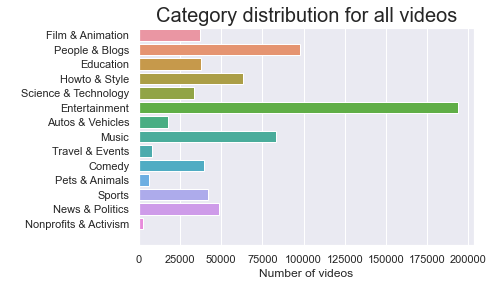

In [19]:
fig = sns.countplot(y = df_videos.categories)
fig.axes.set_title("Category distribution for all videos",fontsize=20)
fig.set_xlabel("Number of videos")
fig.set_ylabel(" ")

plt.show()

In [20]:
# Annotate videos that are neither artistic nor scientific
df_videos["no_art_no_science"] = 1
df_videos["no_art_no_science"].loc[(df_videos.science == 1) | (df_videos.art == 1)] = 0 

df_videos['month_year'] = [datetime(year, month, 1) for year, month in zip(df_videos.upload_date.dt.year, df_videos.upload_date.dt.month)]
month_years = df_videos['month_year'].unique()

# Preparing a Dataframe with the percentages of types of videos timewise
percentages_artistic = []
percentages_scientific = []
percentages_other = []

for month_year in month_years:
    total_videos = ((df_videos['month_year'] == month_year) & (df_videos['art'] == 1)).sum() \
    + ((df_videos['month_year'] == month_year) & (df_videos['science'] == 1)).sum() \
    + ((df_videos['month_year'] == month_year) & (df_videos['no_art_no_science'] == 1)).sum()

    percentages_artistic.append(((df_videos['month_year'] == month_year) & (df_videos['art'] == 1)).sum()/total_videos)
    percentages_scientific.append(((df_videos['month_year'] == month_year) & (df_videos['science'] == 1)).sum()/total_videos)
    percentages_other.append(((df_videos['month_year'] == month_year) & (df_videos['no_art_no_science'] == 1)).sum()/total_videos)

df_art_science = pd.DataFrame({
    'month_year': month_years,
    'art': percentages_artistic,
    'science': percentages_scientific,
    'other': percentages_other,
})

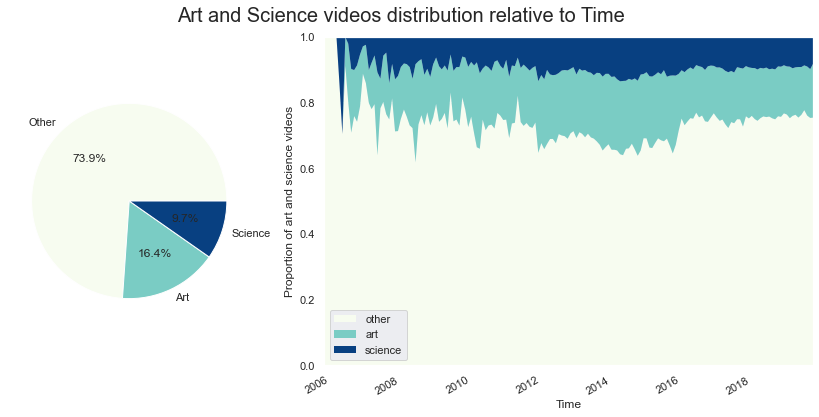

In [24]:
# Pie chart and Time dependence of Art and Science videos proportions
fig, axs = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios':[1, 2]})
fig.tight_layout()
fig.suptitle('Art and Science videos distribution relative to Time', fontsize=20, y=1.03)
plt.subplots_adjust(wspace=0.2, hspace=None)

sum_videos = df_videos[["no_art_no_science", "art", "science"]].sum()
sum_videos.plot(kind="pie", labels = ["Other", "Art", "Science"], autopct='%1.1f%%', colormap = 'GnBu', ax = axs[0])
axs[0].set_ylabel("")

df_art_science.plot.area('month_year', ['other', 'art', 'science'], colormap='GnBu', lw=0, ax = axs[1])
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Proportion of art and science videos')
axs[1].set_xlabel('Time')
axs[1].margins(0)
plt.show()

Here we can see the intersection of scientific and artistic videos in the dataset. 

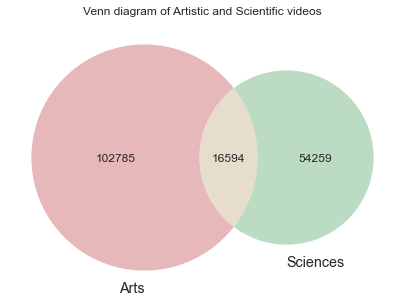

In [37]:
# Making sets out of indexes of Arts and Sciences videos
set_arts = set(df_art.index)
set_science = set(df_science.index)


# Venn diagram 
plt.figure(figsize=(7,7))
plt.title('Venn diagram of Artistic and Scientific videos')
venn2([set_arts, set_science], ['Arts', 'Sciences'])
plt.show()

### Artistic videos

#### Artistic domains distribution and time dependancy

Since we have identified which videos fall under our vision of "Artistic videos", let's look at their distribution within the Categories Youtube has defined:

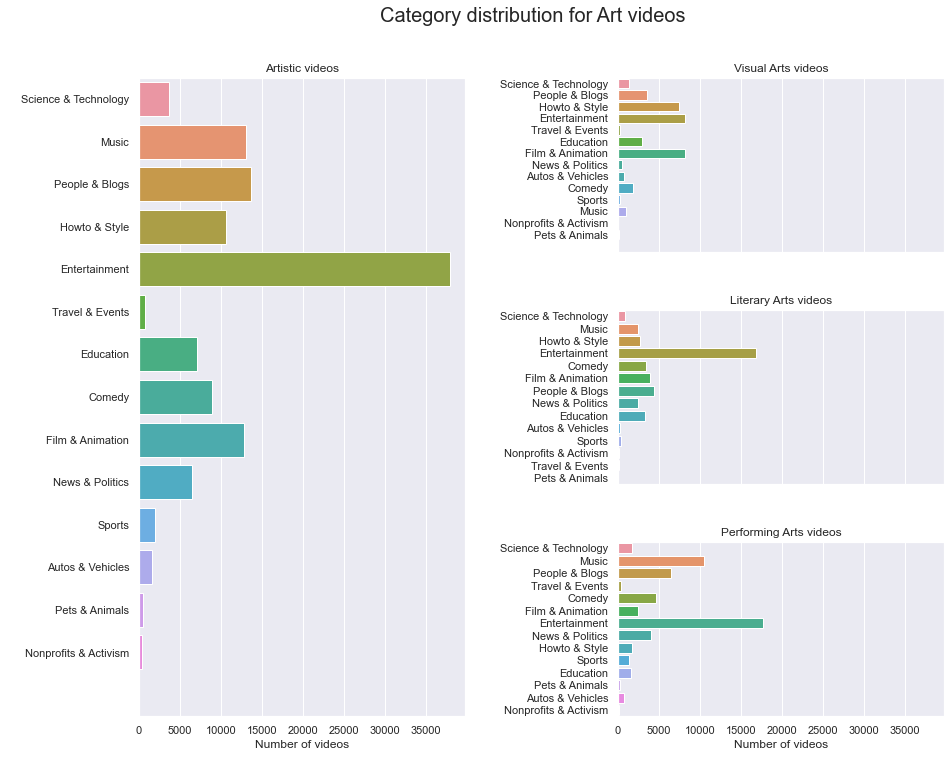

In [25]:
# Bar/count plots of the categories for Art videos
fig, axs = plt.subplot_mosaic([['Left', 'TopRight'],['Left', 'CenterRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]}, figsize=(12,10), sharex = True)
fig.suptitle('Category distribution for Art videos', fontsize=20, y=1.03)
fig.tight_layout(w_pad=10.0, h_pad = 4)

sns.countplot(y = df_art.categories, ax = axs['Left'])
axs['Left'].set_title('Artistic videos')
axs['Left'].set_ylabel(' ')
axs['Left'].set_xlabel('Number of videos')

sns.countplot(y = df_art[df_art.visual_art==1].categories, ax = axs['TopRight'])
axs['TopRight'].set_title('Visual Arts videos')
axs['TopRight'].set_ylabel(' ')
axs['TopRight'].set_xlabel(' ')

sns.countplot(y = df_art[df_art.literary_art==1].categories, ax = axs['CenterRight'])
axs['CenterRight'].set_title('Literary Arts videos')
axs['CenterRight'].set_ylabel(' ')
axs['CenterRight'].set_xlabel(' ')

sns.countplot(y = df_art[df_art.performing_art==1].categories, ax = axs['BottomRight'])
axs['BottomRight'].set_title('Performing Arts videos')
axs['BottomRight'].set_ylabel(' ')
axs['BottomRight'].set_xlabel('Number of videos')

plt.show()

Now lets look at the distribution of Art videos within the domains we chose:

In [38]:
df_art['month_year'] = [datetime(year, month, 1) for year, month in zip(df_art.upload_date.dt.year, df_art.upload_date.dt.month)]
month_years = df_art['month_year'].unique()

percentages_visual = []
percentages_performing = []
percentages_literary = []

# Preparing a Dataframe with the percentages of types of artistic videos timewise
for month_year in month_years:
    total_art_videos = ((df_art['month_year'] == month_year) & (df_art['visual_art'] == 1)).sum() \
    + ((df_art['month_year'] == month_year) & (df_art['performing_art'] == 1)).sum() \
    + ((df_art['month_year'] == month_year) & (df_art['literary_art'] == 1)).sum()

    percentages_visual.append(((df_art['month_year'] == month_year) & (df_art['visual_art'] == 1)).sum()/total_art_videos)
    percentages_performing.append(((df_art['month_year'] == month_year) & (df_art['performing_art'] == 1)).sum()/total_art_videos)
    percentages_literary.append(((df_art['month_year'] == month_year) & (df_art['literary_art'] == 1)).sum()/total_art_videos)

df_art_time = pd.DataFrame({
    'month_year': month_years,
    'percentage_visual': percentages_visual,
    'percentage_performing': percentages_performing,
    'percentage_literary': percentages_literary,
})


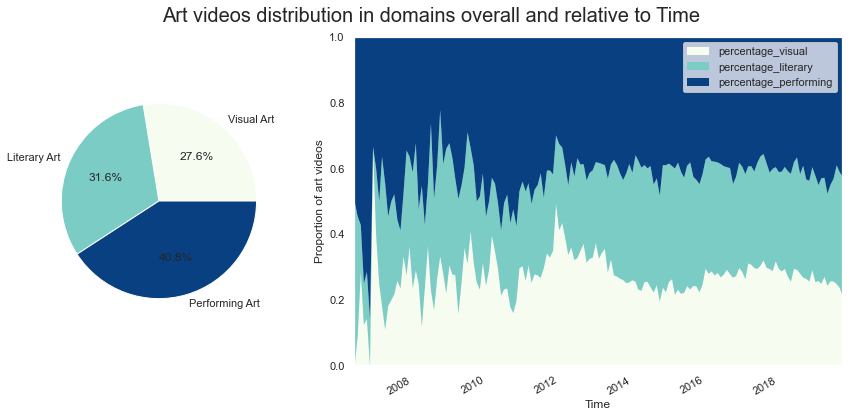

In [39]:
# Pie chart and Time related chart for artistic domain videos

fig, axs = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios':[1, 2]})
fig.tight_layout()
fig.suptitle('Art videos distribution in domains overall and relative to Time', fontsize=20, y=1.03)
plt.subplots_adjust(wspace=0.2, hspace=None)

sum_arts = df_art[["visual_art", "literary_art", "performing_art"]].sum()
sum_arts.plot(kind="pie", labels = ["Visual Art", "Literary Art", "Performing Art"], autopct='%1.1f%%', colormap = 'GnBu', ax = axs[0])
axs[0].set_ylabel("")

df_art_time.plot.area('month_year', ['percentage_visual', 'percentage_literary', 'percentage_performing'], colormap='GnBu', lw=0, ax = axs[1])
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Proportion of art videos')
axs[1].set_xlabel('Time')
axs[1].margins(0)
plt.show()

#### Intersection of artistic domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

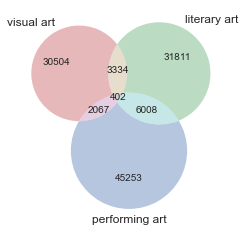

In [24]:
# Getting the videos corresponding to each Art domain
vis = df_art[(df_art['visual_art'] == 1)] 
lit = df_art[(df_art['literary_art'] == 1)]
perf = df_art[(df_art['performing_art'] == 1)]

set1 = set(vis.index)
set2 = set(lit.index)
set3 = set(perf.index)

# Venn diagram of the Artistic videos
plt.figure(figsize=(4,4))
venn3([set1, set2, set3], ['visual art', 'literary art', 'performing art'])
plt.show()

#### Artistic tags usage

In [29]:
# Get the tags that were present in our dictionaries
df_art['visual_art_word'] = df_art['tags'].apply(lambda x : return_word_in_list(x, visual_words))
df_art['literary_art_word'] = df_art['tags'].apply(lambda x : return_word_in_list(x, literary_words))
df_art['performing_art_word'] = df_art['tags'].apply(lambda x : return_word_in_list(x, performing_words))

Most popular dictionary words that classified videos in their domains give us more information about what most popular type of video is actually located in each domain.

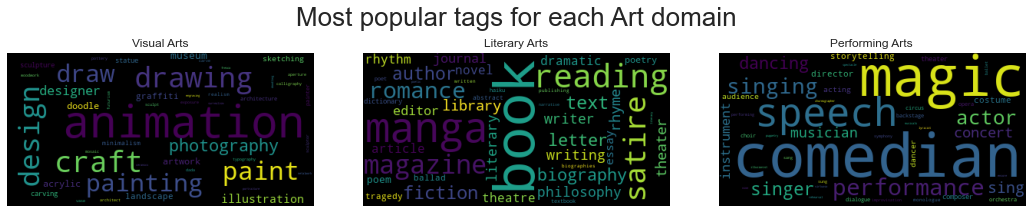

In [30]:
# Preparing lists for Wordclouds
list_vis = []
list_sth=[list_vis.extend(x) for x in df_art.loc[df_art.visual_art == 1].visual_art_word]
visual_string=(" ").join(list_vis)

list_lit = []
list_sth=[list_lit.extend(x) for x in df_art.loc[df_art.literary_art == 1].literary_art_word]
literary_string=(" ").join(list_lit)

list_perf = []
list_sth=[list_perf.extend(x) for x in df_art.loc[df_art.performing_art == 1].performing_art_word]
performing_string=(" ").join(list_perf)

# Wordclouds
wordcloud_vis = WordCloud(collocations=False).generate(visual_string)
wordcloud_lit = WordCloud(collocations=False).generate(literary_string)
wordcloud_perf = WordCloud(collocations=False).generate(performing_string)

# Plots
fig, axs = plt.subplots(1, 3, figsize=(15,3))
fig.suptitle('Most popular tags for each Art domain', fontsize=26)

axs[0].imshow(wordcloud_vis)
axs[0].axis("off")
axs[0].set_title('Visual Arts')

axs[1].imshow(wordcloud_lit)
axs[1].axis("off")
axs[1].set_title('Literary Arts')

axs[2].imshow(wordcloud_perf)
axs[2].axis("off")
axs[2].set_title('Performing Arts')

plt.tight_layout()

### Scientific videos

#### Scientific domains distribution and time dependancy

Similarly, we can look at the distribution within the Youtube categories for our "Science videos":

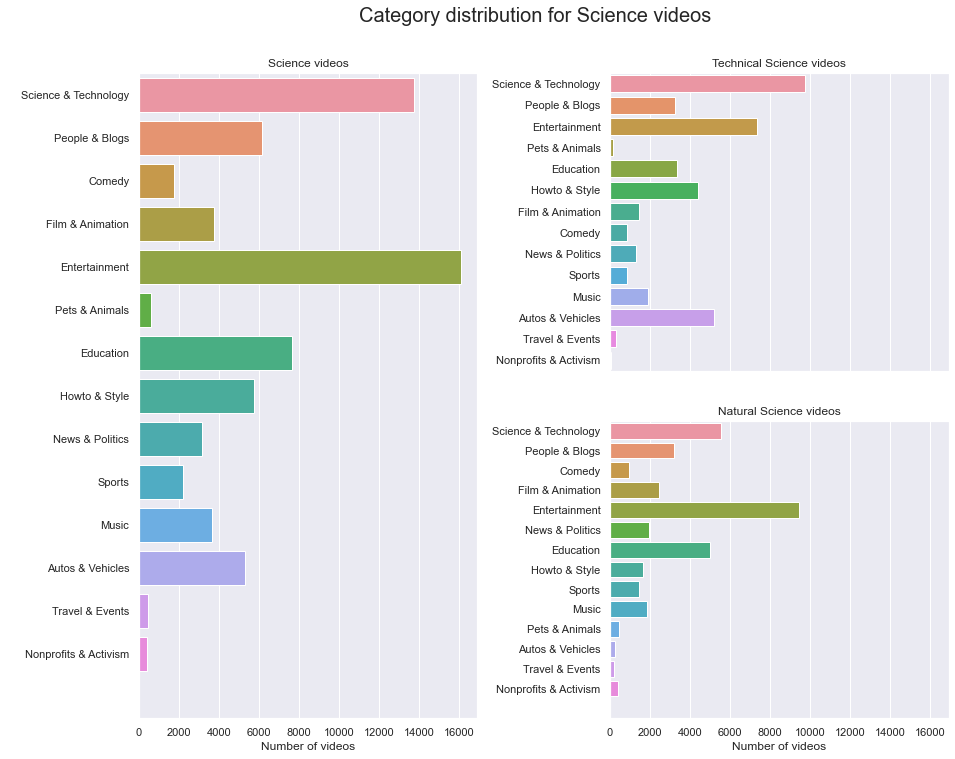

In [27]:
# Bar/count plots of the categories for Science videos
fig, axs = plt.subplot_mosaic([['Left', 'TopRight'],['Left', 'BottomRight']],
                          gridspec_kw={'width_ratios':[1, 1]}, figsize=(12,10), sharex = True)
fig.suptitle('Category distribution for Science videos', fontsize=20, y=1.03)
fig.tight_layout(w_pad=10.0, h_pad = 4)

sns.countplot(y = df_science.categories, ax = axs['Left'])
axs['Left'].set_title('Science videos')
axs['Left'].set_ylabel(' ')
axs['Left'].set_xlabel('Number of videos')

sns.countplot(y = df_science[df_science.technical_science==1].categories, ax = axs['TopRight'])
axs['TopRight'].set_title('Technical Science videos')
axs['TopRight'].set_ylabel(' ')
axs['TopRight'].set_xlabel(' ')

sns.countplot(y = df_science[df_science.natural_science==1].categories, ax = axs['BottomRight'])
axs['BottomRight'].set_title('Natural Science videos')
axs['BottomRight'].set_ylabel(' ')
axs['BottomRight'].set_xlabel('Number of videos')

plt.show()

Now lets look at the distribution of Science videos within the domains we chose:

In [32]:
df_science['month_year'] = [datetime(year, month, 1) for year, month in zip(df_science.upload_date.dt.year, df_science.upload_date.dt.month)]
month_years = df_science['month_year'].unique()

percentages_natural = []
percentages_technical = []

# Preparing a Dataframe with the percentages of types of scientific videos timewise
for month_year in month_years:
    total_science_videos = ((df_science['month_year'] == month_year) & (df_science['natural_science'] == 1)).sum() \
    + ((df_science['month_year'] == month_year) & (df_science['technical_science'] == 1)).sum()

    percentages_natural.append(((df_science['month_year'] == month_year) & (df_science['natural_science'] == 1)).sum()/total_science_videos)
    percentages_technical.append(((df_science['month_year'] == month_year) & (df_science['technical_science'] == 1)).sum()/total_science_videos)


df_science_time = pd.DataFrame({
    'month_year': month_years,
    'percentage_natural': percentages_natural,
    'percentage_technical': percentages_technical,
})

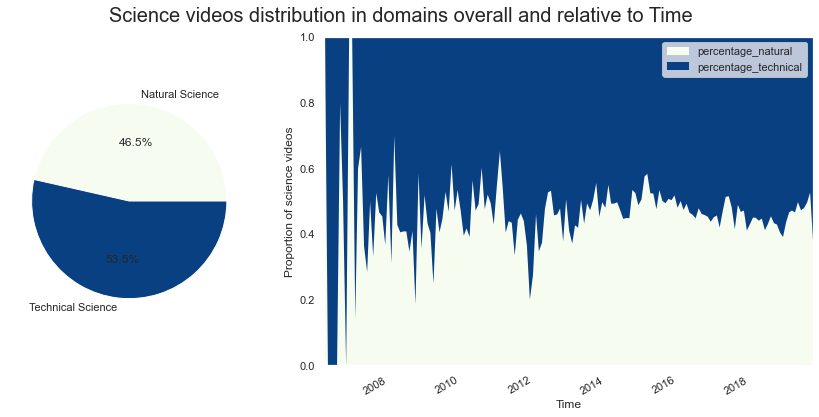

In [33]:
# Pie chart and Time related chart for scientific domain videos

fig, axs = plt.subplots(1, 2, figsize=(12,6), gridspec_kw={'width_ratios':[1, 2]})
fig.tight_layout()
fig.suptitle('Science videos distribution in domains overall and relative to Time', fontsize=20, y=1.03)
plt.subplots_adjust(wspace=0.2, hspace=None)

sum_science = df_science[["natural_science", "technical_science"]].sum()
sum_science.plot(kind="pie", labels = ["Natural Science", "Technical Science"], autopct='%1.1f%%', colormap = 'GnBu', ax = axs[0])
axs[0].set_ylabel("")

df_science_time.plot.area('month_year', ['percentage_natural', 'percentage_technical'], colormap='GnBu', lw=0, ax = axs[1])
axs[1].set_ylim([0, 1])
axs[1].set_ylabel('Proportion of science videos')
axs[1].set_xlabel('Time')
axs[1].margins(0)
plt.show()

#### Intersection of scientific domains

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

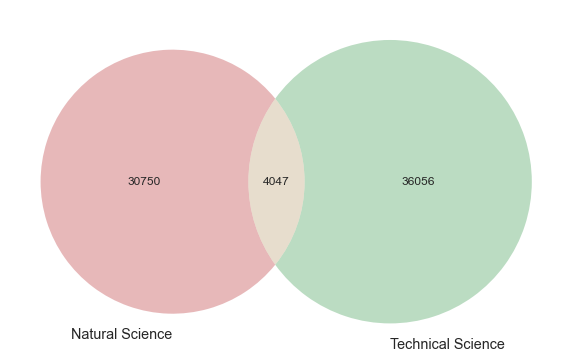

In [34]:
nat = df_science[(df_science['natural_science'] == 1)] 
tec = df_science[(df_science['technical_science'] == 1)]

plt.figure(figsize=(10,10))
set1 = set(nat.index)
set2 = set(tec.index)

venn2([set1, set2], ['Natural Science', 'Technical Science'])

plt.show()

#### Scientific tags usage

In [35]:
# Get the tags that were present in our dictionaries
df_science['natural_science_word'] = df_science['tags'].apply(lambda x : return_word_in_list(x, natural_words))
df_science['technical_science_word'] = df_science['tags'].apply(lambda x : return_word_in_list(x, technical_words))

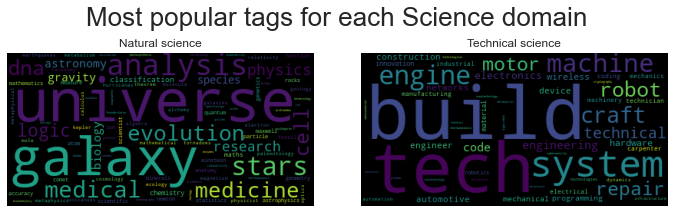

In [36]:
# Preparing lists for Wordclouds
list_nat = []
list_sth=[list_nat.extend(x) for x in df_science.loc[df_science.natural_science == 1].natural_science_word]
natural_string=(" ").join(list_nat)

list_tech = []
list_sth=[list_tech.extend(x) for x in df_science.loc[df_science.technical_science == 1].technical_science_word]
technical_string=(" ").join(list_tech)

# Wordclouds
wordcloud_nat = WordCloud(collocations=False).generate(natural_string)
wordcloud_tech = WordCloud(collocations=False).generate(technical_string)

# Plots
fig, axs = plt.subplots(1, 2, figsize=(10,3))
fig.suptitle('Most popular tags for each Science domain', fontsize=26)

axs[0].imshow(wordcloud_nat)
axs[0].axis("off")
axs[0].set_title('Natural science')

axs[1].imshow(wordcloud_tech)
axs[1].axis("off")
axs[1].set_title('Technical science')

plt.tight_layout()

### Users & comments

In [33]:
df_com = pd.read_feather("comments.feather")

In [34]:
print("We have", len(df_com), "different comments.")
df_com.head()

We have 11999998 different comments.


,author,video_id,likes,replies
0,1,Gkb1QMHrGvA,2,0
1,1,CNtp0xqoods,0,0
2,1,249EEzQmVmQ,1,0
3,1,_U443T2K_Bs,0,0
4,1,rJbjhm0weYc,0,0


In [35]:
df_com_group = df_com.groupby("author").count()

In [36]:
com_mean = df_com_group["video_id"].mean()
geo_mean = stats.gmean(df_com_group["video_id"])
print("There are in average", round(com_mean, 2), "videos commented by user but the distribution has a lot of outliers so we can analyze the geometric mean instead which is:", round(geo_mean, 2))

There are in average 19.36 videos commented by user but the distribution has a lot of outliers so we can analyze the geometric mean instead which is: 3.65


In [37]:
N_outliers = 300
highest_com = df_com_group.loc[df_com_group.video_id > N_outliers]
normal_com = df_com_group.loc[df_com_group.video_id < N_outliers]
perc = highest_com.shape[0]*100/df_com_group.shape[0]
print(round(perc, 2), "% of the commenters commented on more than", N_outliers, "videos.")

0.98 % of the commenters commented on more than 300 videos.


We have a heavy-tailed distribution.


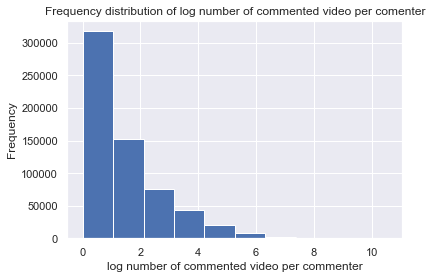

In [38]:
np.log(df_com_group.video_id).plot(kind = "hist")
plt.title("Frequency distribution of log number of commented video per comenter")
plt.xlabel("log number of commented video per commenter")
print("We have a heavy-tailed distribution.")

# Milestone 3

## Prepare the data

In [39]:
df_com_count = df_com_group.drop(columns = ["likes", "replies"])
# rename video_id column to "count_comments"
df_com_count = df_com_count.rename(columns = {"video_id": "count_comments"})

In [40]:
# merge the two dataframes df_videos and df_com on the column "video_id"
df_videos_com = pd.merge(df_videos, df_com, on = "video_id").dropna()
df_videos_com.head(1)

,categories,channel_id,dislike_count,duration,like_count,tags,upload_date,view_count,video_id,visual_art,...,performing_art,art,natural_science,technical_science,science,no_art_no_science,month_year,author,likes,replies
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,2548.0,2196,8780.0,"[lego, batman, movie, the, batman, movie, new,...",2017-02-13,6674760.0,3vQK78eUg2A,0,...,0,0,0,0,0,1,2017-02-01,453667,2,1


In [41]:
df_videos_com_group = df_videos_com.groupby("author").sum()
df_videos_com_group.head(1)

,dislike_count,duration,like_count,view_count,visual_art,literary_art,performing_art,art,natural_science,technical_science,science,no_art_no_science,likes,replies
author,,,,,,,,,,,,,,
1,3502.0,1512,196022.0,6487215.0,0,0,0,0,0,0,0,2,1,0


In [42]:
df_videos_com_group.drop(columns=["dislike_count", "duration", "like_count", "view_count", "likes", "replies"], inplace=True)

In [43]:
#concatenate the two dataframes df_videos_com_group and df_com_count
df_com_art_science = pd.concat([df_videos_com_group, df_com_count], axis=1)
df_com_art_science.head()

,visual_art,literary_art,performing_art,art,natural_science,technical_science,science,no_art_no_science,count_comments
author,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,6
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
16,1.0,5.0,3.0,7.0,5.0,0.0,5.0,48.0,777
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,18


## EDA on our new DataFrame

In [44]:
# print percentage of authors that commented art videos and science videos
print(
    "Percentage of authors that commented art videos:",
    round(
        df_com_art_science.loc[df_com_art_science.art > 0].shape[0]
        * 100
        / df_com_art_science.shape[0],
        2,
    ),
    "%",
)
print(
    "Percentage of authors that commented science videos:",
    round(
        df_com_art_science.loc[df_com_art_science.science > 0].shape[0]
        * 100
        / df_com_art_science.shape[0],
        2,
    ),
    "%",
)


Percentage of authors that commented art videos: 15.61 %
Percentage of authors that commented science videos: 8.87 %


In [45]:
# print percentage of authors that commented art videos among the authors that commented science videos
print(
    "Percentage of authors that commented art videos among the authors that commented science videos:",
    round(
        df_com_art_science.loc[(df_com_art_science.art > 0) & (df_com_art_science.science > 0)].shape[0]
        * 100
        / df_com_art_science.loc[df_com_art_science.science > 0].shape[0],
        2,
    ),
    "%",
)


Percentage of authors that commented art videos among the authors that commented science videos: 63.07 %


In [46]:
# print percentage of authors that commented scince videos among the authors that commented art videos
print(
    "Percentage of authors that commented science videos among the authors that commented art videos:",
    round(
        df_com_art_science.loc[(df_com_art_science.art > 0) & (df_com_art_science.science > 0)].shape[0]
        * 100
        / df_com_art_science.loc[df_com_art_science.art > 0].shape[0],
        2,
    ),
    "%",
)

Percentage of authors that commented science videos among the authors that commented art videos: 35.84 %


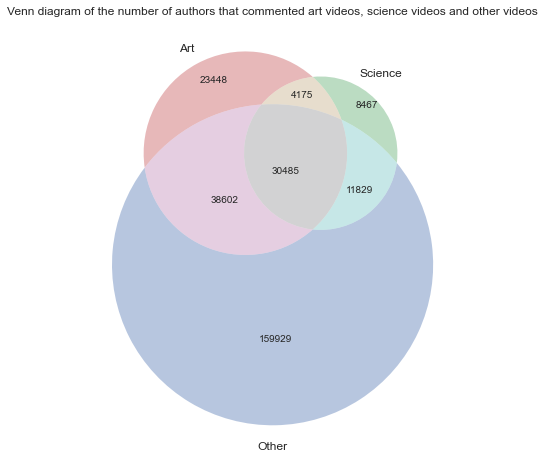

In [47]:
# Getting the videos corresponding to each Art domain
art = df_com_art_science[(df_com_art_science['art'] > 0)] 
science = df_com_art_science[(df_com_art_science['science'] > 0)]
other = df_com_art_science[(df_com_art_science['no_art_no_science'] > 0)]

set1 = set(art.index)
set2 = set(science.index)
set3 = set(other.index)

# Venn diagram of the Artistic videos
plt.figure(figsize=(8,8))
venn3([set1, set2, set3], ['Art', 'Science', 'Other'])

# Increase size of the graph
plt.title("Venn diagram of the number of authors that commented art videos, science videos and other videos")

plt.show()

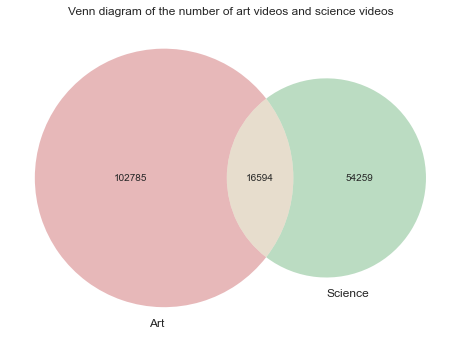

In [48]:
# Getting the videos corresponding to each Art domain
art = df_videos[(df_videos['art'] > 0)] 
science = df_videos[(df_videos['science'] > 0)]

set1 = set(art.index)
set2 = set(science.index)

# Venn diagram of the Artistic videos
plt.figure(figsize=(8,8))
venn2([set1, set2], ['Art', 'Science'])

plt.title("Venn diagram of the number of art videos and science videos")

plt.show()

In [49]:
# # Getting the videos corresponding to each Art domain
# art = df_com_art_science[(df_com_art_science['art'] > 0)] 
# science = df_com_art_science[(df_com_art_science['science'] > 0)]
# other = df_com_art_science[(df_com_art_science['no_art_no_science'] > 0)]
# visual_arts = df_com_art_science[(df_com_art_science['visual_art'] > 0)]
# literary_arts = df_com_art_science[(df_com_art_science['literary_art'] > 0)]
# performing_arts = df_com_art_science[(df_com_art_science['performing_art'] > 0)]
# natural_science = df_com_art_science[(df_com_art_science['natural_science'] > 0)]
# technical_science = df_com_art_science[(df_com_art_science['technical_science'] > 0)]

# set1 = set(art.index)
# set2 = set(science.index)
# set3 = set(other.index)
# set4 = set(visual_arts.index)
# set5 = set(literary_arts.index)
# set6 = set(performing_arts.index)
# set7 = set(natural_science.index)
# set8 = set(technical_science.index)

# # Venn diagram of the Artistic videos
# plt.figure(figsize=(8,8))
# venn8([set1, set2, set3, set4, set5, set6, set7, set8], ['Art', 'Science', 'Other', "visual_arts", "literary_arts", "performing_arts", "natural_science", "technical_science"])

# # Increase size of the graph
# plt.title("Venn diagram of the number of authors that commented art videos, science videos and other videos")

# plt.show()

In [50]:
art_science_commenters = len(df_com_art_science[(df_com_art_science['art'] > 0) & (df_com_art_science['science'] > 0)])

art_commenters = len(df_com_art_science[(df_com_art_science['art'] > 0)])
only_art_commenters = len(df_com_art_science[(df_com_art_science['art'] > 0) & (df_com_art_science['science'] == 0)])
art_tech_science_commenters = len(df_com_art_science[(df_com_art_science['art'] > 0) & (df_com_art_science['technical_science'] > 0)])
art_nat_science_commenters = len(df_com_art_science[(df_com_art_science['art'] > 0) & (df_com_art_science['natural_science'] > 0)])

science_commenters = len(df_com_art_science[(df_com_art_science['science'] > 0)])
only_science_commenters = len(df_com_art_science[(df_com_art_science['science'] > 0) & (df_com_art_science['art'] == 0)])
science_visu_art_commenters = len(df_com_art_science[(df_com_art_science['science'] > 0) & (df_com_art_science['visual_art'] > 0)])
science_lit_art_commenters = len(df_com_art_science[(df_com_art_science['science'] > 0) & (df_com_art_science['literary_art'] > 0)])
science_perf_art_commenters = len(df_com_art_science[(df_com_art_science['science'] > 0) & (df_com_art_science['performing_art'] > 0)])

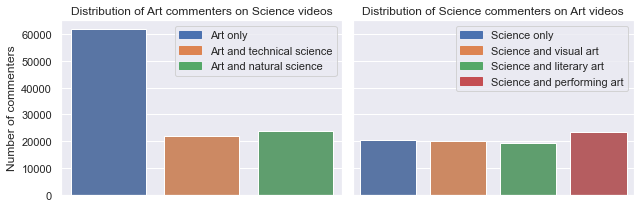

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3), sharey = True)

axs[0].set_ylabel('Number of commenters')

# Art commenters w.r.t Science
categories = ['Art only', 'Art and technical science', 'Art and natural science']
values = [only_art_commenters, art_tech_science_commenters, art_nat_science_commenters]
plot = sns.barplot(x=categories, y=values, ax=axs[0])
axs[0].set_title('Distribution of Art commenters on Science videos')

patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
axs[0].legend(handles=patches)
axs[0].tick_params(axis='x', labelbottom=False) 

# Science commenters w.r.t Art
categories = ['Science only', 'Science and visual art', 'Science and literary art', 'Science and performing art']
values = [only_science_commenters, science_visu_art_commenters, science_lit_art_commenters, science_perf_art_commenters]
plot = sns.barplot(x=categories, y=values, ax=axs[1])
axs[1].set_title('Distribution of Science commenters on Art videos')

patches = [mpl.patches.Patch(color=sns.color_palette()[i], label=t) for i,t in enumerate(t.get_text() for t in plot.get_xticklabels())]
axs[1].legend(handles=patches)
axs[1].tick_params(axis='x', labelbottom=False) 

plt.tight_layout()
plt.show()

In [52]:
print(only_science_commenters, science_visu_art_commenters, science_lit_art_commenters, science_perf_art_commenters)

20296 19994 19244 23470


## Bipartite graph

### First Graph

In [183]:
def graph_format(row):
    target_list = []
    columns = ['visual_art','literary_art', 'performing_art', 'natural_science', 'technical_science', 'no_art_no_science']
    for col in columns:
        if row[col] > 0:
            target_list.append(col)

    return target_list


In [184]:
df_edge_list = df_com_art_science.sample(1000).reset_index()
#remove science and art columns from the dataframe
df_edge_list.drop(columns=['art', 'science'], inplace=True)
df_edge_list['target'] = df_edge_list.apply(lambda x: graph_format(x), axis = 1)
df_edge_list.drop(columns=['visual_art','literary_art', 'performing_art', 'natural_science', 'technical_science', 'no_art_no_science', 'count_comments'], inplace=True)
df_edge_list = df_edge_list.explode('target')
df_edge_list = df_edge_list.rename(columns={"author": "source"})
df_edge_list= df_edge_list.dropna()
df_edge_list.head()

,source,target
0,37057,no_art_no_science
1,388479,literary_art
1,388479,performing_art
1,388479,no_art_no_science
2,221466,no_art_no_science


In [185]:
# source = authors
source_nodes = df_edge_list['source'].unique().tolist()

# targets = video domains
target_nodes = df_edge_list['target'].unique().tolist()

# edges as tuples
list_edges = list(df_edge_list.itertuples(index=False, name=None))


In [186]:
B = nx.Graph()
B.add_nodes_from(source_nodes, bipartite=0)
B.add_nodes_from(target_nodes, bipartite=1)
B.add_edges_from(list_edges)

print(B)

Graph with 1006 nodes and 1656 edges


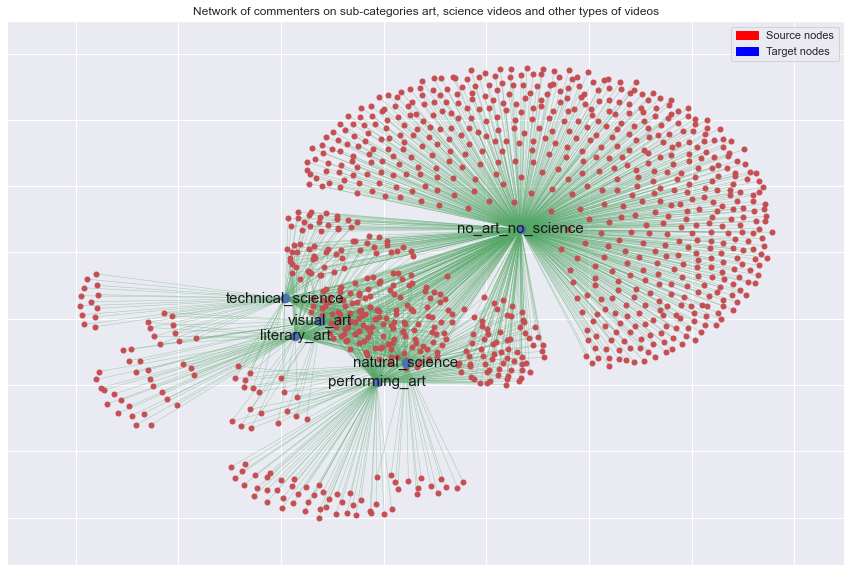

In [187]:
# create a dictionary of labels for the target nodes
labels = {}
for node in target_nodes:
    labels[node] = node

# plot the graph
plt.figure(figsize=(15,10))
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=source_nodes, node_color='r', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='b', node_size=75)
nx.draw_networkx_edges(B, pos, edgelist=list_edges, width=0.5, alpha=0.5, edge_color='g')

# draw the labels for the target nodes
nx.draw_networkx_labels(B, pos, labels, font_size=15, font_color='k')
plt.title('Network of commenters on sub-categories art, science videos and other types of videos')
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Source nodes')
blue_patch = mpatches.Patch(color='blue', label='Target nodes')
plt.legend(handles=[red_patch, blue_patch])
plt.show()


### 1bis graph

In [197]:
def graph_format(row):
    target_list = []
    columns = ['art','science', 'no_art_no_science']
    for col in columns:
        if row[col] > 0:
            target_list.append(col)

    return target_list
df_edge_list = df_com_art_science.sample(1000).reset_index()
#remove science and art columns from the dataframe
df_edge_list['target'] = df_edge_list.apply(lambda x: graph_format(x), axis = 1)
df_edge_list.drop(columns=['visual_art','literary_art', 'performing_art', 'natural_science', 'technical_science', 'no_art_no_science', 'count_comments', "art", "science"], inplace=True)
df_edge_list = df_edge_list.explode('target')
df_edge_list = df_edge_list.rename(columns={"author": "source"})
df_edge_list= df_edge_list.dropna()
df_edge_list.head()

,source,target
0,463874,no_art_no_science
1,627410,science
1,627410,no_art_no_science
2,100737,no_art_no_science
3,303200,no_art_no_science


Graph with 1003 nodes and 1428 edges


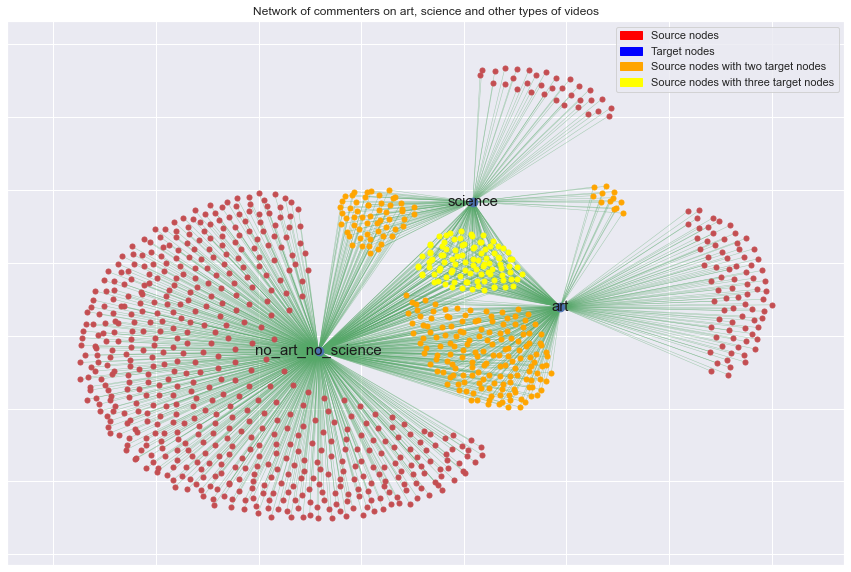

In [198]:
# source = authors
source_nodes = df_edge_list['source'].unique().tolist()

# targets = video domains
target_nodes = df_edge_list['target'].unique().tolist()

# two_nodes are sources nodes with at least two target nodes
two_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 2)['source'].unique().tolist()

three_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 3)['source'].unique().tolist()

#remove two_nodes from source_nodes
source_nodes = [x for x in source_nodes if x not in two_nodes and x not in three_nodes]

# edges as tuples
list_edges = list(df_edge_list.itertuples(index=False, name=None))

B = nx.Graph()
B.add_nodes_from(source_nodes, bipartite=0)
B.add_nodes_from(target_nodes, bipartite=1)
B.add_nodes_from(two_nodes, bipartite=2)
B.add_nodes_from(three_nodes, bipartite=3)
B.add_edges_from(list_edges)

print(B)

# create a dictionary of labels for the target nodes
labels = {}
for node in target_nodes:
    labels[node] = node

# plot the graph
plt.figure(figsize=(15,10))
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=source_nodes, node_color='r', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='b', node_size=75)
nx.draw_networkx_edges(B, pos, edgelist=list_edges, width=0.5, alpha=0.5, edge_color='g')
nx.draw_networkx_nodes(B, pos, nodelist=two_nodes, node_color='orange', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=three_nodes, node_color='yellow', node_size=25)

# draw the labels for the target nodes
nx.draw_networkx_labels(B, pos, labels, font_size=15, font_color='k')
plt.title('Network of commenters on art, science and other types of videos')

#make a legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Source nodes')
blue_patch = mpatches.Patch(color='blue', label='Target nodes')
orange_patch = mpatches.Patch(color='orange', label='Source nodes with two target nodes')
yellow_patch = mpatches.Patch(color='yellow', label='Source nodes with three target nodes')
plt.legend(handles=[red_patch, blue_patch, orange_patch, yellow_patch])

plt.show()


### Second graph

Graph with 1004 nodes and 1769 edges


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


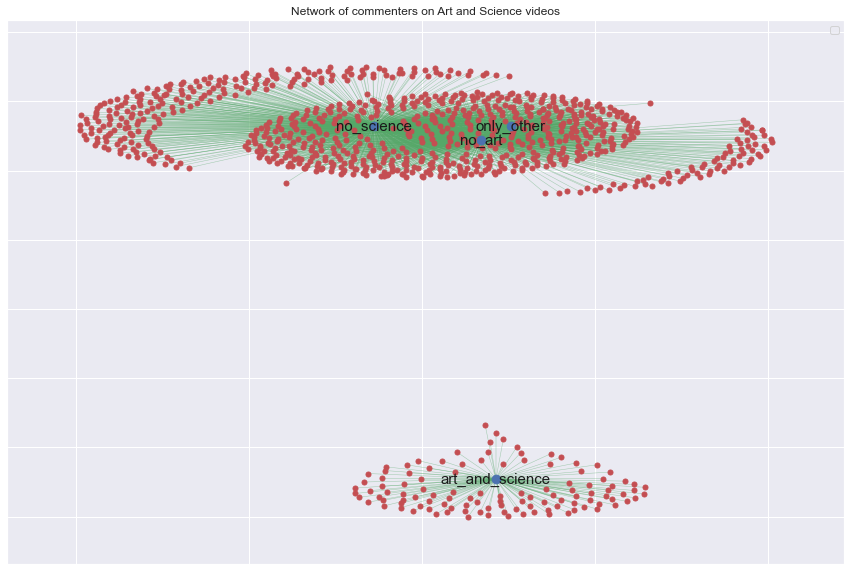

In [191]:
def graph_format(row):
    target_list = []
    columns = ['no_art','no_science', 'only_other', 'art_and_science']
    for col in columns:
        if row[col] > 0:
            target_list.append(col)

    return target_list

df_edge_list = df_com_art_science.sample(1000).reset_index()
df_edge_list["no_art"] = 0
df_edge_list["no_art"].loc[(df_edge_list['art'] == 0)] = 1
df_edge_list["no_science"] = 0
df_edge_list["no_science"].loc[(df_edge_list['science'] == 0)] = 1
df_edge_list["only_other"] = 0
df_edge_list["only_other"].loc[df_edge_list["no_art_no_science"] == df_edge_list["count_comments"]] = 1
df_edge_list["art_and_science"] = 0
df_edge_list["art_and_science"].loc[(df_edge_list["art"] > 0) & (df_edge_list["science"] >0)] = 1
df_edge_list.drop(columns=['visual_art', 'literary_art', "performing_art", "natural_science", "technical_science"], inplace=True)
df_edge_list['target'] = df_edge_list.apply(lambda x: graph_format(x), axis = 1)
df_edge_list.drop(columns=['art','science', 'no_art', 'no_science', 'only_other', 'art_and_science', "count_comments", "no_art_no_science"], inplace=True)
df_edge_list = df_edge_list.explode('target')
df_edge_list = df_edge_list.rename(columns={"author": "source"})
df_edge_list= df_edge_list.dropna()
# source = authors
source_nodes = df_edge_list['source'].unique().tolist()

# targets = video domains
target_nodes = df_edge_list['target'].unique().tolist()

# edges as tuples
list_edges = list(df_edge_list.itertuples(index=False, name=None))

B = nx.Graph()
B.add_nodes_from(source_nodes, bipartite=0)
B.add_nodes_from(target_nodes, bipartite=1)
B.add_edges_from(list_edges)

print(B)

# create a dictionary of labels for the target nodes
labels = {}
for node in target_nodes:
    labels[node] = node

# plot the graph
plt.figure(figsize=(15,10))
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=source_nodes, node_color='r', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='b', node_size=75)
nx.draw_networkx_edges(B, pos, edgelist=list_edges, width=0.5, alpha=0.5, edge_color='g')

# draw the labels for the target nodes
nx.draw_networkx_labels(B, pos, labels, font_size=15, font_color='k')
plt.title('Network of commenters on Art and Science videos')
plt.legend()
plt.show()


### Third one

In [199]:
def graph_format(row):
    target_list = []
    columns = ['visual_art','literary_art', 'performing_art', 'natural_science', 'technical_science']
    for col in columns:
        if row[col] > 0:
            target_list.append(col)

    return target_list
df_edge_list = df_com_art_science.sample(3000).reset_index()
#remove science and art columns from the dataframe
df_edge_list.drop(columns=['art', 'science'], inplace=True)
df_edge_list['target'] = df_edge_list.apply(lambda x: graph_format(x), axis = 1)
df_edge_list.drop(columns=['visual_art','literary_art', 'performing_art', 'natural_science', 'technical_science', 'no_art_no_science', 'count_comments'], inplace=True)
df_edge_list = df_edge_list.explode('target')
df_edge_list = df_edge_list.rename(columns={"author": "source"})
df_edge_list= df_edge_list.dropna()
df_edge_list.head()



,source,target
7,102938,literary_art
7,102938,natural_science
10,382853,literary_art
14,715725,performing_art
14,715725,natural_science


In [200]:
# source = authors
source_nodes = df_edge_list['source'].unique().tolist()

# targets = video domains
target_nodes = df_edge_list['target'].unique().tolist()

# two_nodes are sources nodes with at least two target nodes
two_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 2)['source'].unique().tolist()

three_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 3)['source'].unique().tolist()

four_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 4)['source'].unique().tolist()

five_nodes = df_edge_list.groupby('source').filter(lambda x: len(x) == 5)['source'].unique().tolist()

#remove two_nodes from source_nodes
source_nodes = [x for x in source_nodes if x not in two_nodes and x not in three_nodes and x not in four_nodes and x not in five_nodes]

# edges as tuples
list_edges = list(df_edge_list.itertuples(index=False, name=None))
B = nx.Graph()
B.add_nodes_from(source_nodes, bipartite=0)
B.add_nodes_from(target_nodes, bipartite=1)
B.add_nodes_from(two_nodes, bipartite=2)
B.add_nodes_from(three_nodes, bipartite=3)
B.add_nodes_from(four_nodes, bipartite=4)
B.add_nodes_from(five_nodes, bipartite=5)
B.add_edges_from(list_edges)

print(B)
# create a dictionary of labels for the target nodes


Graph with 1253 nodes and 2250 edges


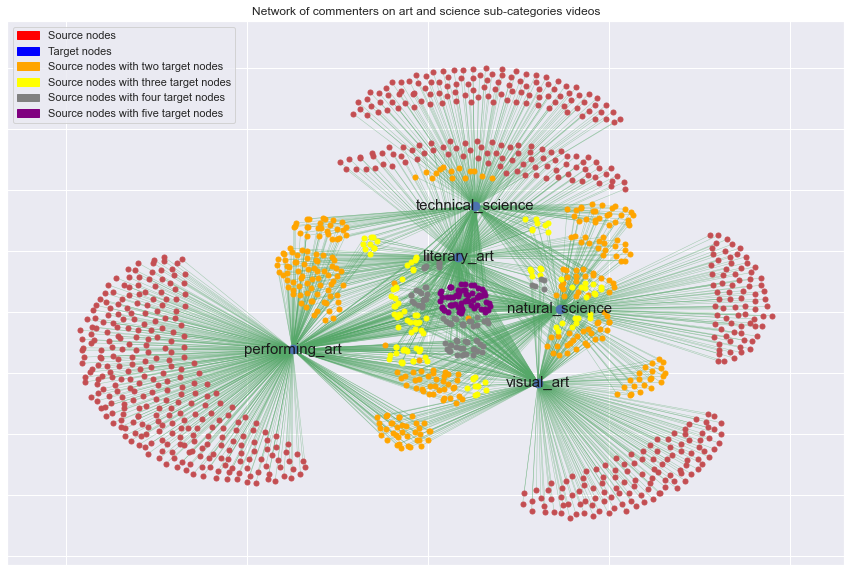

In [202]:
labels = {}
for node in target_nodes:
    labels[node] = node

# plot the graph
plt.figure(figsize=(15,10))
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=source_nodes, node_color='r', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=two_nodes, node_color='orange', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=three_nodes, node_color='yellow', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=four_nodes, node_color='grey', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=five_nodes, node_color='purple', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='b', node_size=75)
nx.draw_networkx_edges(B, pos, edgelist=list_edges, width=0.5, alpha=0.5, edge_color='g')

# draw the labels for the target nodes
nx.draw_networkx_labels(B, pos, labels, font_size=15, font_color='k')
plt.title('Network of commenters on art and science sub-categories videos')
# plt.legend()

import matplotlib.patches as mpatches

#make a legend
red_patch = mpatches.Patch(color='red', label='Source nodes')
blue_patch = mpatches.Patch(color='blue', label='Target nodes')
orange_patch = mpatches.Patch(color='orange', label='Source nodes with two target nodes')
yellow_patch = mpatches.Patch(color='yellow', label='Source nodes with three target nodes')
grey_patch = mpatches.Patch(color='grey', label='Source nodes with four target nodes')
black_patch = mpatches.Patch(color='purple', label='Source nodes with five target nodes')
plt.legend(handles=[red_patch, blue_patch, orange_patch, yellow_patch, grey_patch, black_patch])

plt.show()

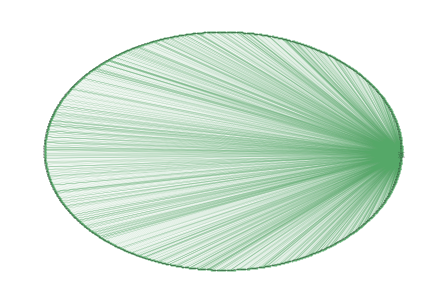

In [94]:
# Draw the graph with a circular layout instead?
nx.draw_circular(B, with_labels=True,  node_color='g', alpha = 0.8, node_size=1, font_size=0, font_color='k', width=0.1, edge_color='g')

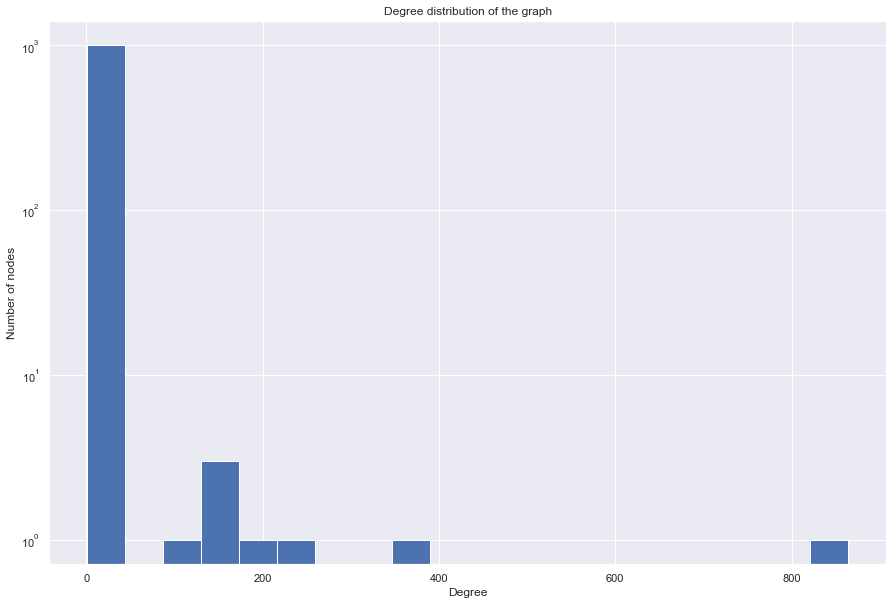

In [96]:
# plot the degree distribution of the graph
plt.figure(figsize=(15,10))
plt.hist([d for n, d in B.degree()], bins=20, log=True)
plt.title('Degree distribution of the graph')
plt.xlabel('Degree')
plt.ylabel('Number of nodes')
plt.show()

In [99]:
# Helper function for plotting the degree distribution of a Graph
def plot_degree_distribution(G):
    degrees = {}
    for node in G.nodes():
        degree = G.degree(node)
        if degree not in degrees:
            degrees[degree] = 0
        degrees[degree] += 1
    sorted_degree = sorted(degrees.items())
    deg = [k for (k,v) in sorted_degree]
    cnt = [v for (k,v) in sorted_degree]
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')
    plt.title("Degree Distribution")
    plt.ylabel("Frequency")
    plt.xlabel("Degree")
    ax.set_xticks([d+0.05 for d in deg])
    ax.set_xticklabels(deg)

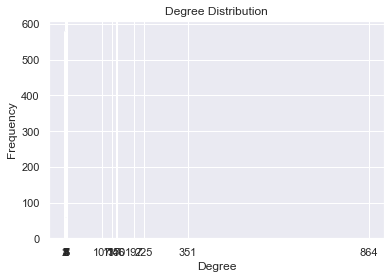

In [100]:
plot_degree_distribution(B)

In [ ]:
# create a dictionary of labels for the target nodes
labels = {}
for node in target_nodes:
    labels[node] = node

# plot the graph
plt.figure(figsize=(15,10))
pos = nx.spring_layout(B)
nx.draw_networkx_nodes(B, pos, nodelist=source_nodes, node_color='r', node_size=25)
nx.draw_networkx_nodes(B, pos, nodelist=target_nodes, node_color='b', node_size=75)
nx.draw_networkx_edges(B, pos, edgelist=list_edges, width=0.5, alpha=0.5, edge_color='g')

# draw the source nodes with two edges in orange


# draw the labels for the target nodes
nx.draw_networkx_labels(B, pos, labels, font_size=10, font_color='k')
plt.title('Network of commenters on Art and Science videos')

plt.show()


In [57]:
# # Separate by group
# l, r = nx.bipartite.sets(B)
# pos = {}

# # Update position for node from each group
# pos.update((node, (1, index)) for index, node in enumerate(l))
# pos.update((node, (2, index)) for index, node in enumerate(r))

# nx.draw(B, pos=pos)
# plt.show()

In [58]:
# # First specify the nodes you want on left or top
# left_or_top = df_edge_list['source'].unique()

# # Then create a bipartite layout
# pos = nx.bipartite_layout(B, left_or_top)

# # Pass that layout to nx.draw
# nx.draw(B,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,
#      edge_cmap=plt.cm.Blues,with_labels=True)

## Statistical tests

### T-Test

In [59]:
df_com_art_science.dropna(inplace=True)
df_com_art_science

,visual_art,literary_art,performing_art,art,natural_science,technical_science,science,no_art_no_science,count_comments
author,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,6
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
16,1.0,5.0,3.0,7.0,5.0,0.0,5.0,48.0,777
19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,18
...,...,...,...,...,...,...,...,...,...
796511,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5
796512,0.0,1.0,1.0,1.0,0.0,0.0,0.0,2.0,8
796515,1.0,1.0,3.0,5.0,1.0,0.0,1.0,12.0,79


For the statistical tests we need every time two distributions that we can compare.
For example here we will try to compare:
- The distribution over the authors of the probability they comment on an artistic video
$$P_{ca}(author) = \frac{N_{ca}(author)}{N_{Vtot}}$$
**Versus**
- The distribution over the *scientific* authors of the probability they comment on an artistic video
  $$P_{ca}(author|scientific) = \frac{N_{ca}(author|scientific)}{N_{Vtot}}$$
where $N_{ca}(author)$ is the number of comments on artistic videos for a given author and $N_{Vtot}$ is the total number of videos

In [60]:
num_video_tot = df_videos_com.video_id.nunique()
num_video_tot

705745

<AxesSubplot:xlabel='art', ylabel='Count'>

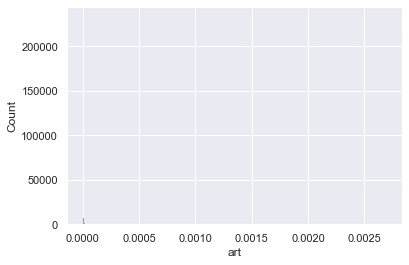

In [61]:
# define probabilities
sns.histplot(df_com_art_science['art']/num_video_tot, bins=1000)

# hardcore power law need to display with log axes

In [62]:
# now do the test
p_ca_scientific = df_com_art_science[df_com_art_science['science'] > 0]['art']/num_video_tot
p_ca = (df_com_art_science['art']/num_video_tot).sample(len(p_ca_scientific))      # To have the same length

_, p = stats.wilcoxon(p_ca_scientific, p_ca)
p

0.0

In [63]:
# IDK, not sure of what I am doing right now

### Linear Regression Analysis

We will try to use linear regression in order to answer these two questions

1. Who is more probable to comment on an *visual/literary/performing* art video: *technical* scientists or *natural* scientists ?
2. Who is more probable to comment on a *technical/natural* science video: *visual* artists, *performing* artists or *literary* artists ?


In [64]:
def plot_summary(ax, regression_result):
    """
    Helper function to display the summary of a linear regression model.
    Code inspired from tutorial 4 on regression analysis.
    """
    # dependent variable name
    dep_variable = regression_result.model.endog_names

    # feature names
    variables = regression_result.params.index
    # coefficients
    coefficients = regression_result.params.values
    # p-values
    p_values = regression_result.pvalues
    # standard errors
    standard_errors = regression_result.bse.values

    # sort them all by coefficients
    l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

    # in this case, we index starting from the first element, not to plot the intercept
    # we will use standard errors, instead of CIs
    # two standard errors approximate the CIs (you can actually see in the summary table that
    # +/2 SI is equivalent to the CIs)
    ax.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
                linestyle = 'none', marker = 'o', markersize= 3,
                markerfacecolor = 'white', markeredgecolor = 'blue', capsize= 5)

    ax.vlines(0,0, len(l1), linestyle = '--')

    ax.set_yticks(range(len(l2)), l2)

    # additionnal parameters
    ax.text(
        0.1, 0.90,
        'R²: %.3f' % (res.rsquared),
        transform=ax.transAxes,
        fontsize=12,
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    )

    ax.set_title(dep_variable)

Let's define theses two sets so we can use them in our linear regression models.

**Arts:**
$$A = \{A_1, A_2, A_3\} = \{\text{visual}, \text{literary}, \text{performing}\}, \quad A_i \in \N$$
**Sciences:**
$$S = \{S_1, S_2\} = \{\text{technical}, \text{natural}\}, \quad S_i \in \N$$

Each corresponds to the number of comments a user makes on videos from different domains.

To also compare the coefficents we will get with videos not labeled with art nor science, we need to add this type of comments in the model as well.

We'll denote them as $$Q \coloneqq \text{number of comments on non-art and non-science videos}$$

In [65]:
arts = ['visual_art', 'literary_art', 'performing_art']
sciences = ['technical_science', 'natural_science']

#### 1. Artists
**Question**: 
Who is more probable to comment on an *visual/literary/performing* art video: *technical* scientists or *natural* scientists ?

Let's start with the first question with the following models for artists:
$$ A_j = \beta_0 + \sum_{i=1}^2 \beta_i S_i + \beta_3 Q, \quad j=1,\dots,3$$

In [66]:
art_models = ['%s ~ %s + %s + %s' % (art, *sciences, 'no_art_no_science')  for art in arts]
art_models

['visual_art ~ technical_science + natural_science + no_art_no_science',
 'literary_art ~ technical_science + natural_science + no_art_no_science',
 'performing_art ~ technical_science + natural_science + no_art_no_science']

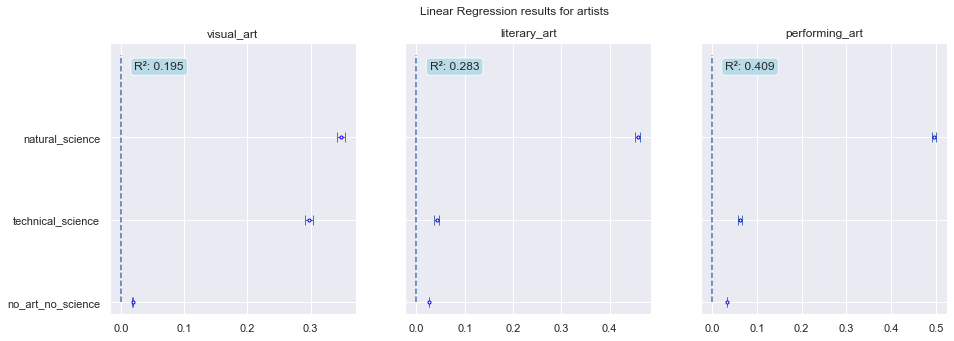

In [67]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
fig.suptitle("Linear Regression results for artists")

for i, model in enumerate(art_models):
    mod = smf.ols(formula=model, data=df_com_art_science)
    res = mod.fit()

    plot_summary(axs[i], res)
    

**<span style='color:red'>[Discuss results here]</span>**

#### 2. Scientists
**Question**:
Who is more probable to comment on a *technical/natural* science video: *visual* artists, *performing* artists or *literary* artists ?

For the second question we define the following models for scientists:
$$ S_j = \beta_0 + \sum_{i=1}^3 \beta_i A_i + \beta_4 Q, \quad j=1,\dots,2$$

In [68]:
science_models = ['%s ~ %s + %s + %s + %s' % (science, *arts, 'no_art_no_science')  for science in sciences]
science_models

['technical_science ~ visual_art + literary_art + performing_art + no_art_no_science',
 'natural_science ~ visual_art + literary_art + performing_art + no_art_no_science']

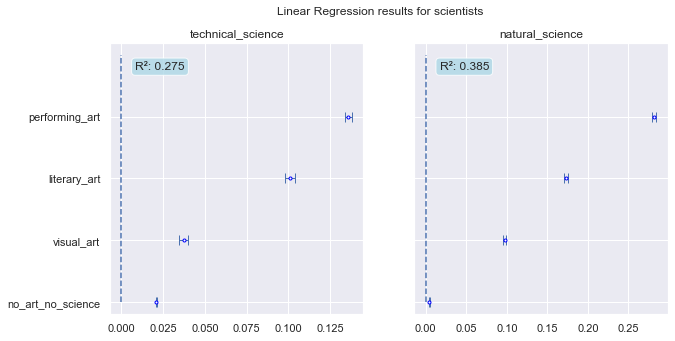

In [69]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 5))
fig.suptitle("Linear Regression results for scientists")

for i, model in enumerate(science_models):
    mod = smf.ols(formula=model, data=df_com_art_science)
    res = mod.fit()

    plot_summary(axs[i], res)
    

**<span style='color:red'>[Discuss results here]</span>**

### T-Test

#### Artistic people interested in Science videos ?

In [70]:
import numpy as np
from scipy import stats

# Calculate the null hypothesis mean (average number of comments on science videos for all authors)
null_hypothesis_mean = df_com_art_science["science"].sum() / df_com_art_science.shape[0]

# Calculate the alternative hypothesis mean (average number of comments on science videos for authors who have commented on at least one art video)
alternative_hypothesis_mean = df_com_art_science["science"][df_com_art_science["art"] > 0].mean()

# Calculate the standard deviation of the number of comments on science videos for authors who have commented on at least one art video
standard_deviation = np.sqrt(df_com_art_science[df_com_art_science["art"] > 0]["science"].apply(lambda x: (x - alternative_hypothesis_mean)**2).sum() / (df_com_art_science[df_com_art_science["art"] > 0].shape[0] - 1))

# Calculate the t-statistic
t_statistic, p_value = stats.ttest_1samp(df_com_art_science[df_com_art_science["art"] > 0]["science"], null_hypothesis_mean)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.  It means that there is a significant difference between the number of comments that authors who comment on art videos write on science videos and the average number of comments that all authors write on science videos".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis. It means that there is no significant difference between the number of comments that authors who comment on art videos write on science videos and the average number of comments that all authors write on science videos".format(p_value, significance_level))


The p-value of 1.130222688183174e-265 is less than the significance level of 0.05, so we can reject the null hypothesis.  It means that there is a significant difference between the number of comments that authors who comment on art videos write on science videos and the average number of comments that all authors write on science videos


#### Scientific people interested in Art videos ?

In [71]:
import numpy as np
from scipy import stats

# Calculate the null hypothesis mean (average number of comments on art videos for all authors)
null_hypothesis_mean = df_com_art_science["art"].sum() / df_com_art_science.shape[0]

# Calculate the alternative hypothesis mean (average number of comments on art videos for authors who have commented on at least one science video)
alternative_hypothesis_mean = df_com_art_science[df_com_art_science["science"] > 0]["art"].mean()

# Calculate the standard deviation of the number of comments on art videos for authors who have commented on at least one science video
standard_deviation = np.sqrt(df_com_art_science[df_com_art_science["science"] > 0]["art"].apply(lambda x: (x - alternative_hypothesis_mean)**2).sum() / (df_com_art_science[df_com_art_science["science"] > 0].shape[0] - 1))

# Calculate the t-statistic
t_statistic, p_value = stats.ttest_1samp(df_com_art_science[df_com_art_science["science"] > 0]["art"], null_hypothesis_mean)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))


The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


### Wilcoxon test

Non-parametric statistical tests which do not assume normality

#### Artistic people interested in Science videos ?

In [72]:
from scipy.stats import wilcoxon

# Calculate the null hypothesis mean (average number of comments on science videos for all authors)
null_hypothesis_mean = df_com_art_science["science"].sum() / df_com_art_science.shape[0]

# Calculate the difference between the number of comments on science videos for each author who has commented on at least one art video and the null hypothesis mean
differences = df_com_art_science[df_com_art_science["art"] > 0]["science"] - null_hypothesis_mean

# Conduct the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(differences)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))


The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


#### Scientific people interested in Art videos ?

In [73]:
from scipy.stats import wilcoxon

# Calculate the null hypothesis mean (average number of comments on art videos for all authors)
null_hypothesis_mean = df_com_art_science["art"].sum() / df_com_art_science.shape[0]

# Calculate the difference between the number of comments on art videos for each author who has commented on at least science video and the null hypothesis mean
differences = df_com_art_science[df_com_art_science["science"] > 0]["art"] - null_hypothesis_mean

# Conduct the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(differences)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))


The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


### Welch's t-test

Non-parametric statistical tests which do not assume normality

#### Artistic people interested in Science videos ?

In [74]:
from scipy.stats import ttest_ind

# Conduct the Welch's t-test
t_statistic, p_value = ttest_ind(df_com_art_science[df_com_art_science["art"] > 0]["science"], df_com_art_science["science"], equal_var=False)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))

The p-value of 2.3340573873381046e-236 is less than the significance level of 0.05, so we can reject the null hypothesis.


#### Scientific people interested in Art videos ?

In [75]:
from scipy.stats import ttest_ind

# Conduct the Welch's t-test
t_statistic, p_value = ttest_ind(df_com_art_science[df_com_art_science["science"] > 0]["art"], df_com_art_science["art"], equal_var=False)

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))

The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


###  Mann-Whitney U test

Non-parametric statistical tests which do not assume normality

#### Artistic people interested in Science videos ?

In [76]:
from scipy.stats import mannwhitneyu

# Conduct the Mann-Whitney U test
t_statistic, p_value = mannwhitneyu(df_com_art_science[df_com_art_science["art"] > 0]["science"], df_com_art_science["science"])

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))


The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


#### Scientific people interested in Art videos ?

In [77]:
from scipy.stats import mannwhitneyu

# Conduct the Mann-Whitney U test
t_statistic, p_value = mannwhitneyu(df_com_art_science[df_com_art_science["science"] > 0]["art"], df_com_art_science["art"])

# Compare the p-value to the significance level
significance_level = 0.05  # You can choose a different significance level if desired
if p_value < significance_level:
    print("The p-value of {} is less than the significance level of {}, so we can reject the null hypothesis.".format(p_value, significance_level))
else:
    print("The p-value of {} is not less than the significance level of {}, so we cannot reject the null hypothesis.".format(p_value, significance_level))


The p-value of 0.0 is less than the significance level of 0.05, so we can reject the null hypothesis.


## Plots to visualize

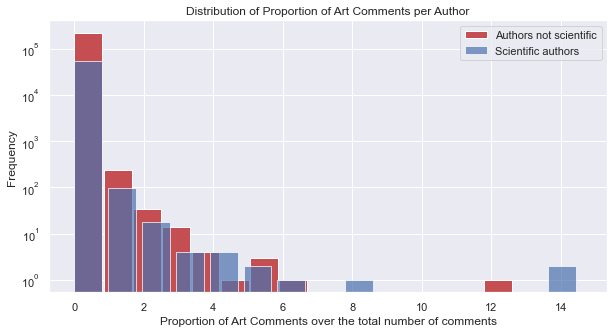

In [78]:
plt.figure(figsize=(10, 5))
mean = np.mean(df_com_art_science['art'])
std = np.std(df_com_art_science['art'])
plt.hist(df_com_art_science[df_com_art_science["science"] == 0]["art"]/np.mean(df_com_art_science[df_com_art_science["science"] == 0]["count_comments"]), bins=15, log=True, color="r", width =0.8, label= "Authors not scientific")
plt.hist(df_com_art_science[df_com_art_science["science"] > 0]["art"]/np.mean(df_com_art_science[df_com_art_science["science"] > 0]["count_comments"]), bins=15, log=True, color="b", alpha = 0.7, width =0.8, label= "Scientific authors")
plt.ylabel('Frequency')
plt.xlabel('Proportion of Art Comments over the total number of comments')
plt.title('Distribution of Proportion of Art Comments per Author')
plt.legend()
plt.show()


In [79]:
perc_0art_no_science = round(len(df_com_art_science.loc[(df_com_art_science["science"] == 0) & (df_com_art_science["art"] == 0)])/len(df_com_art_science.loc[df_com_art_science["science"] == 0]), 2)
perc_0art_science = round(len(df_com_art_science.loc[(df_com_art_science["science"] > 0) & (df_com_art_science["art"] == 0)])/len(df_com_art_science.loc[df_com_art_science["science"] > 0]), 2)
print("Percentage of authors who have not commented on any art video and are not scientific: {} %".format(perc_0art_no_science*100))
print("Percentage of authors who have not commented on any art video and are scientific: {} %".format(perc_0art_science*100))

Percentage of authors who have not commented on any art video and are not scientific: 72.0 %
Percentage of authors who have not commented on any art video and are scientific: 37.0 %
